## 0.- Imports necesarios para el clustering de los datos

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import copy
import json
import joblib
import plotly.express as px
import warnings 
from numpy import unique,where

from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import LabelEncoder

from kmodes.kprototypes import KPrototypes

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, silhouette_samples

## 1.- Leer el fichero de datos de los pacientes con diabetes

Como en el análisis estadístico ya hemos limpiado y preprocesado el dataset solo tenemos que cargarlo y quedarnos con las variables relevantes

### 1.1.- Cargamos el fichero en la variable df

In [31]:
# Path al fichero de datos
file_path = 'diabetes_data_clean.csv'

# Leemos el fichero como un df de Pandas
df = pd.read_csv(file_path)

# Imprimimos la cabecera para ver si ha cargado
df.head()

,Diabetes_012,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0,1,1,1,40,1,0,0,0,0,...,1,0,5,18,15,1,0,9,4,3
1,0,0,0,0,25,1,0,0,1,0,...,0,1,3,0,0,0,0,7,6,1
2,0,1,1,1,28,0,0,0,0,1,...,1,1,5,30,30,1,0,9,4,8
3,0,1,0,1,27,0,0,0,1,1,...,1,0,2,0,0,0,0,11,3,6
4,0,1,1,1,24,0,0,0,1,1,...,1,0,2,3,0,0,0,11,5,4


### 1.2.- Obeservamos dimensiones del dataset y los nombres de columnas con sus tipos

In [32]:
# Numero de filas y columnas en el df
filas, columnas = df.shape
print(f"Numero de filas: {filas}")
print(f"Numero de columnas: {columnas}")

Numero de filas: 229781
Numero de columnas: 22


In [33]:
# Nombres de las columnas
nombres_columnas = df.columns
print("Columnas del df:", nombres_columnas)

Columnas del df: Index(['Diabetes_012', 'HighBP', 'HighChol', 'CholCheck', 'BMI', 'Smoker',
       'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies',
       'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth',
       'MentHlth', 'PhysHlth', 'DiffWalk', 'Sex', 'Age', 'Education',
       'Income'],
      dtype='object')


### 1.3.- Reducción del dataset

A diferencia del K means el resto de algorimtos requieren de mucha RAM, más de la que se puede emplear en el desarrollo de este TFM. Por ellos vamos a quedarnos con una muestra significativa del dataset con 4000 de cada categoria de diabetes a partir de ahora para hacer el clustering

In [34]:
# Función que coge un conjunto random de tamaño 5000 para cada grupo
def get_random_sample(group, n=5000):
    return group.sample(n=min(n, group.shape[0]), random_state=42)

clustering_df_original = copy.deepcopy(df)

df_sampled = df.groupby('Diabetes_012', group_keys=False).apply(get_random_sample, n=4000)

df_sampled.reset_index(inplace=True)


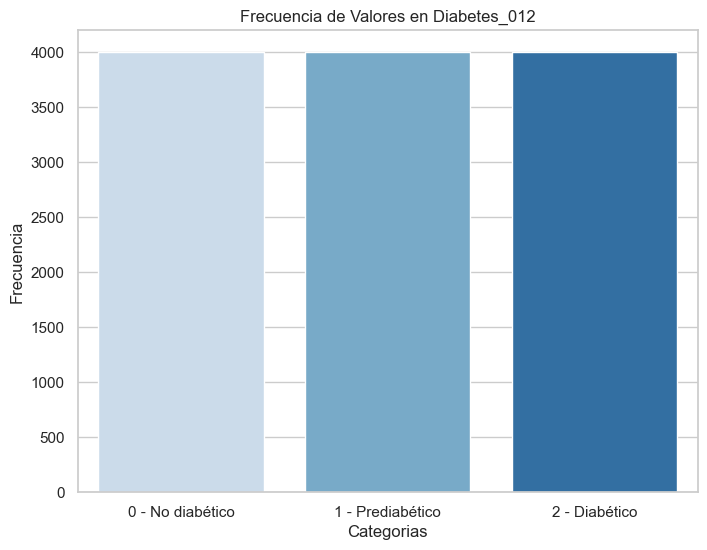

In [35]:
# Definimos un mapeo de etiquetas para los valores en 'Diabetes_012'
etiquetas = {0: 'No diabético', 1: 'Prediabético', 2: 'Diabético'}

# Cereamos una copia a modificar
df_graficas = df_sampled.copy()
df_graficas['Diabetes_012'] = df_graficas['Diabetes_012'].map(etiquetas)

# Gráfica de barras con barras estrechas, color azul, cuadrícula y leyenda
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
ax = sns.countplot(data=df_graficas, x='Diabetes_012', palette="Blues")
plt.title("Frecuencia de Valores en Diabetes_012")
plt.xlabel("Categorias")
plt.ylabel("Frecuencia")

# Personaliza la leyenda
legend_labels = [f"{key} - {value}" for key, value in etiquetas.items()]
ax.set_xticklabels(legend_labels)

plt.show()

In [36]:
print(df_sampled.value_counts("Diabetes_012"))
clustering_df = df_sampled.drop(columns=['Diabetes_012','index'])

clustering_df.to_csv('clustering_df_reducido.csv', index=False)

# Numero de filas y columnas en el df
filas, columnas = clustering_df.shape
print(f"Numero de filas: {filas}")
print(f"Numero de columnas: {columnas}")



Diabetes_012
0    4000
1    4000
2    4000
dtype: int64
Numero de filas: 12000
Numero de columnas: 21


## 2.- Definición del modelo K-Prototypes (Basado en Centroides)

### 2.1.- Cálculo del número óptimo de clusters

Para k-prototypes como vemos en el estado del arte, el método más empleado para determinar el número de clusters es el de la inercia.

In [37]:
# Lista para almacenar las inercias
inertias = []

# Números de clusters para probar
k_values = range(1, 10)

# Ignoramos los warning
warnings.filterwarnings("ignore", category=FutureWarning)

In [38]:
clustering_df = pd.read_csv('clustering_df_reducido.csv')

columnas_numericas = ['MentHlth', 'PhysHlth', 'BMI', 'Age']
columnas_categoricas = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'DiffWalk', 'Sex', 'Education', 'Income']


# Convertir las variables categóricas a códigos numéricos usando LabelEncoder
label_encoders = {}
for column in columnas_categoricas:
    label_encoders[column] = LabelEncoder()
    clustering_df[column] = pd.Categorical(label_encoders[column].fit_transform(clustering_df[column]))

clustering_df.head()

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,1,1,1,33,0,0,0,1,1,1,...,1,0,2,0,0,0,0,6,5,6
1,1,1,1,33,1,0,0,0,1,1,...,1,0,2,14,0,1,0,9,5,6
2,0,0,1,25,1,0,0,1,1,1,...,1,0,0,0,0,0,1,6,3,6
3,1,1,1,26,0,0,0,1,0,1,...,1,0,1,0,0,0,0,13,2,2
4,0,0,1,15,0,0,0,1,0,1,...,1,0,1,0,1,0,1,5,5,7


In [39]:
columnas_numericas = ['MentHlth', 'PhysHlth', 'BMI', 'Age']
columnas_categoricas = ['HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'GenHlth', 'DiffWalk', 'Sex', 'Education', 'Income']


for k in k_values:
    clusterer = KPrototypes(n_clusters=k, init='Cao', random_state=42)
    
    indices_columnas_categoricas = [clustering_df.columns.get_loc(col) for col in columnas_categoricas]

    # Entrenar el modelo
    clusterer.fit(
        clustering_df[columnas_numericas + columnas_categoricas].values,
        categorical=indices_columnas_categoricas
    )
    
    # Obtener la inercia y almacenarla en la lista
    inertias.append(clusterer.cost_)

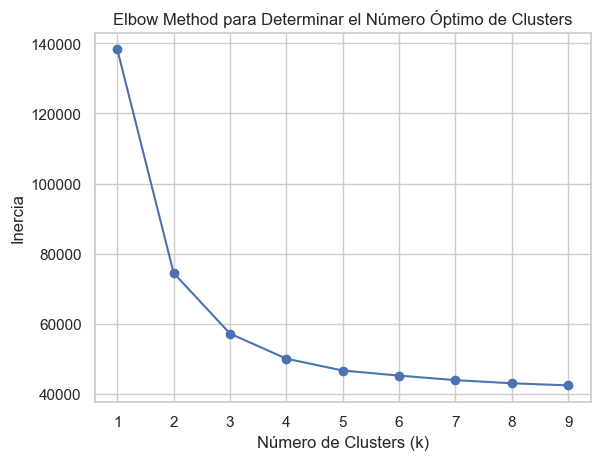

In [40]:
# Graficar la curva de la inercia en función del número de clusters para determinar el número óptimo
plt.plot(k_values, inertias, marker='o')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.title('Elbow Method para Determinar el Número Óptimo de Clusters')
plt.show()

### 2.2.- Definición del modelo

In [41]:
total_clusters = 3 # En base a la grafica anterior cogemos el codo de la misma 
clusterer = KPrototypes(n_clusters=total_clusters, init='Cao', random_state=42)

### 2.3.- Obtenemos las etiquetas (Cluster al que pertenece) para cada dato

In [42]:
# Obtener los índices de las columnas categóricas
indices_columnas_categoricas = [clustering_df.columns.get_loc(col) for col in columnas_categoricas]

# Entrenar el modelo
labels = clusterer.fit_predict(
    clustering_df[columnas_numericas + columnas_categoricas].values,
    categorical=indices_columnas_categoricas
)

### 2.4.- Agregar las etiquetas de clusters y de clasificacion al conjunto de datos


In [43]:
clustering_df["cluster_label"] = labels
clustering_df["diabetic_label"] = df_sampled["Diabetes_012"]

clustering_df.head()
clustering_df.to_csv('resultados/df_clusters/kprototypes.csv')

### 2.5.- Resumen de pertenencia de clusters por grupo de diabetes

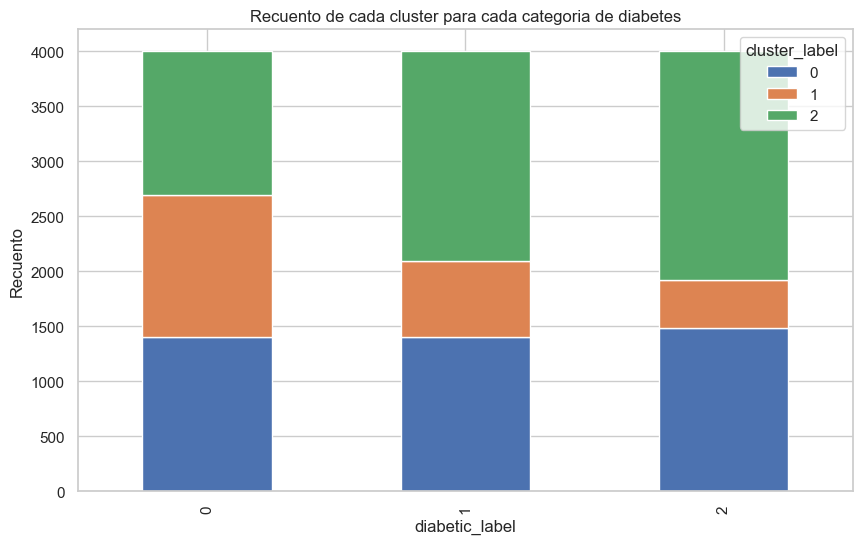

In [44]:

# Agrupa por 'diabetic_label' y 'cluster_label' y cuenta las ocurrencias
df_agrupado = clustering_df.groupby(['diabetic_label', 'cluster_label']).size().unstack()

# Crear el gráfico de barras
df_agrupado.plot(kind='bar', stacked=True, figsize=(10, 6))

# Configurar el título y etiquetas
plt.title('Recuento de cada cluster para cada categoria de diabetes')
plt.xlabel('diabetic_label')
plt.ylabel('Recuento')

# Mostrar el gráfico
plt.show()

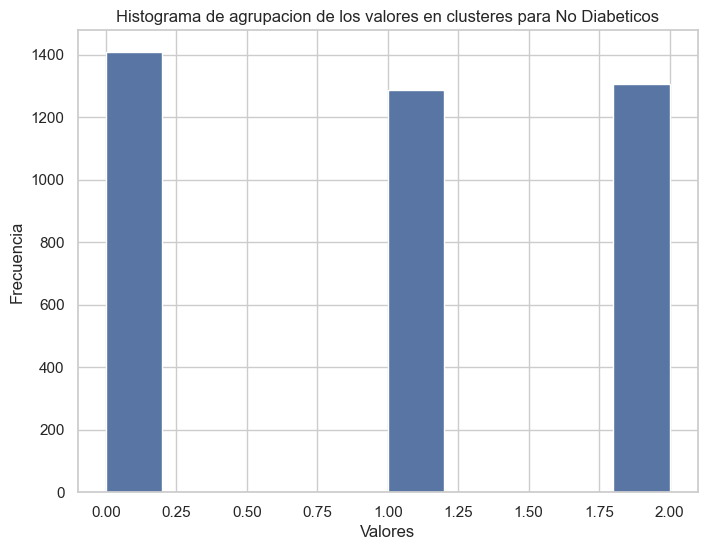

In [45]:
# Miramos el histograma de cada categoria en detalle
data = clustering_df[clustering_df['diabetic_label'] == 0]['cluster_label']
plt.figure(figsize=(8, 6))
plt.hist(data, color="#5975A4")
plt.title("Histograma de agrupacion de los valores en clusteres para No Diabeticos")
plt.xlabel("Valores")
plt.ylabel("Frecuencia")
plt.show()

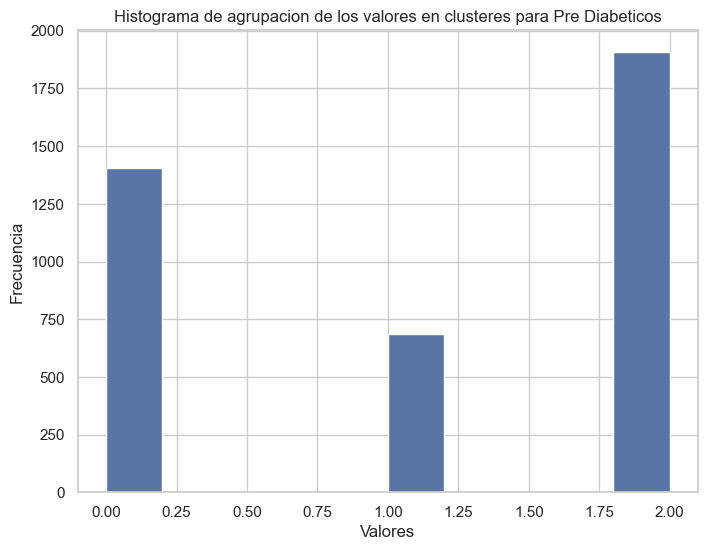

In [46]:
# Miramos el histograma de cada categoria en detalle
data = clustering_df[clustering_df['diabetic_label'] == 1]['cluster_label']
plt.figure(figsize=(8, 6))
plt.hist(data, color="#5975A4")
plt.title("Histograma de agrupacion de los valores en clusteres para Pre Diabeticos")
plt.xlabel("Valores")
plt.ylabel("Frecuencia")
plt.show()

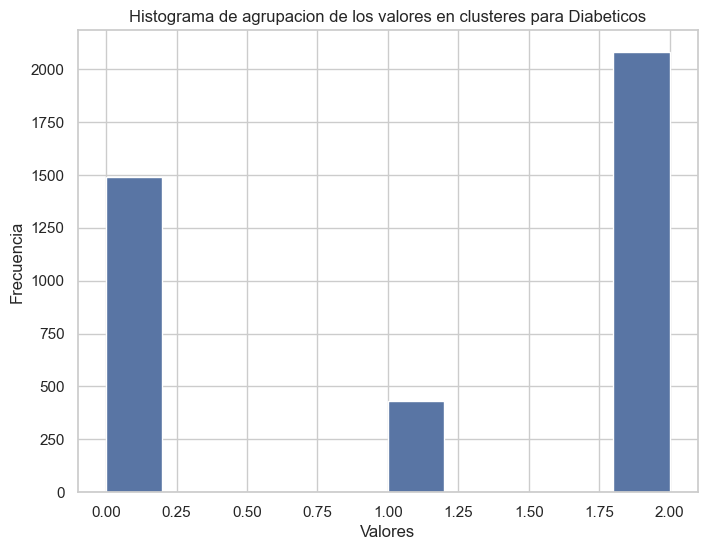

In [47]:
# Miramos el histograma de cada categoria en detalle
data = clustering_df[clustering_df['diabetic_label'] == 2]['cluster_label']
plt.figure(figsize=(8, 6))
plt.hist(data, color="#5975A4")
plt.title("Histograma de agrupacion de los valores en clusteres para Diabeticos")
plt.xlabel("Valores")
plt.ylabel("Frecuencia")
plt.show()

### 2.6.- Resumen general de pertenencia de las categorias de diabetes a los clusters

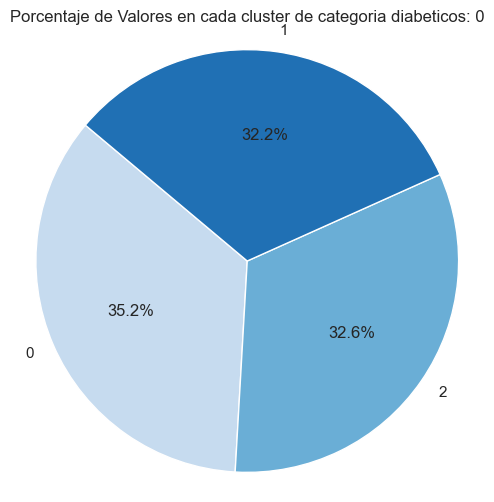

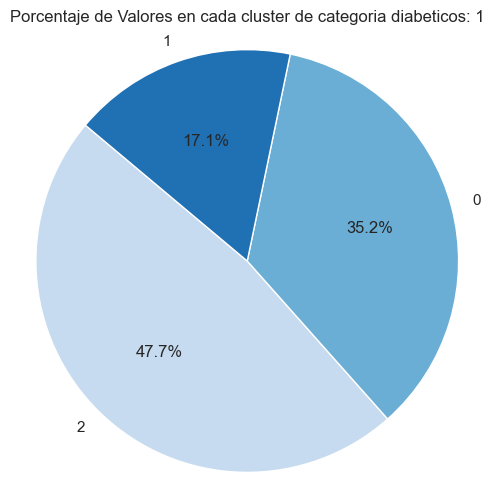

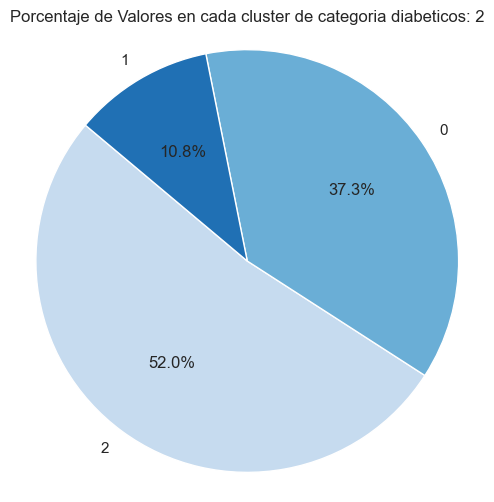

In [48]:
for diabetic_value in clustering_df['diabetic_label'].unique():
    
    # Pintamos el pie plot para esta categoria de diabetes
    df_class =  clustering_df[clustering_df['diabetic_label'] == diabetic_value]
    plt.figure(figsize=(6, 6))
    labels = df_class['cluster_label'].value_counts().index
    sizes = df_class['cluster_label'].value_counts().values
    plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Blues", n_colors=total_clusters))
    plt.title(f"Porcentaje de Valores en cada cluster de categoria diabeticos: {diabetic_value}")
    plt.axis('equal') 
    plt.show()

    

### 2.7.- Análisis estadístico de los clusters

In [49]:
for cluster_number in list(range(total_clusters)):
    # Guardamos las descripción a un csv
    description_df = clustering_df[clustering_df['cluster_label'] == cluster_number].drop(columns=['diabetic_label', 'cluster_label']).describe()
    description_df.to_csv(f'resultados\\kprototypes\\kprototypes_estadisticas_cluster{cluster_number}.csv', sep=',', float_format='%.2f', index=False)

    # Guardamos la moda a un csv
    mode_df = clustering_df[clustering_df['cluster_label'] == cluster_number].drop(columns=['diabetic_label', 'cluster_label']).mode()
    mode_df.to_csv(f'resultados\\kprototypes\\kprototypes_moda_cluster{cluster_number}.csv', sep=',', float_format='%.2f', index=False)


### 2.8.- Evaluación de calidad

In [50]:
evaluacion_calidad = {}

In [51]:
clustering_df = pd.read_csv('clustering_df_reducido.csv')

# Indice de silueta
silhouette_avg = silhouette_score(clustering_df, clusterer.labels_)
print("El índice de silueta promedio es:", silhouette_avg)

# Indice de Davies-Bouldin
davies_bouldin = davies_bouldin_score(clustering_df, clusterer.labels_)
print("El índice de Davies-Bouldin es:", davies_bouldin)

evaluacion_calidad["kprototypes"] = {"silueta": silhouette_avg, "davies_bouldin": davies_bouldin}

El índice de silueta promedio es: 0.043009343313334475
El índice de Davies-Bouldin es: 6.197203226941025


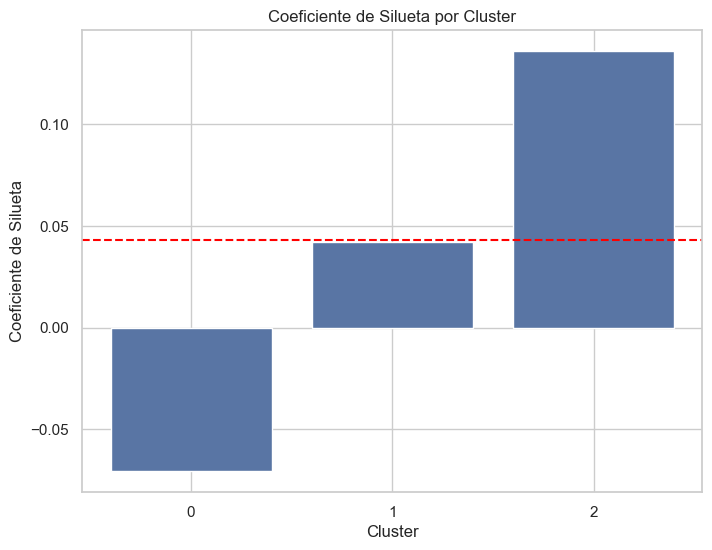

In [52]:
# Calculamos el coeficiente de Silueta promedio
silhouette_avg = silhouette_score(clustering_df, clusterer.labels_)

# Calculamos el coeficiente de Silueta para cada muestra
sample_silhouette_values = silhouette_samples(clustering_df, clusterer.labels_)

# Creamos una lista para almacenar los coeficientes de Silueta promedio por cluster
cluster_silhouette_avg = []

# Creamos un bucle para obtener el coeficiente de Silueta para cada cluster
list_siluetes = []
for cluster in range(max(clusterer.labels_)+1):
    # Obtenemos las muestras pertenecientes al cluster actual
    cluster_silhouette_values = sample_silhouette_values[clusterer.labels_ == cluster]
    
    # Calculamos el coeficiente de Silueta promedio para el cluster actual
    avg_silhouette = np.mean(cluster_silhouette_values)

    cluster_dict = {'category': cluster, 'value': avg_silhouette}
    list_siluetes.append(cluster_dict)
    
    # Almacenamos el coeficiente de Silueta promedio en la lista
    cluster_silhouette_avg.append(avg_silhouette)

# Creamos el gráfico de barras
plt.figure(figsize=(8, 6))
plt.bar(range(len(cluster_silhouette_avg)), cluster_silhouette_avg, color="#5975A4")
plt.title('Coeficiente de Silueta por Cluster')
plt.xlabel('Cluster')
plt.ylabel('Coeficiente de Silueta')
plt.xticks(range(len(cluster_silhouette_avg)))
plt.axhline(y=silhouette_avg, color="red", linestyle="--")  # Línea para indicar el valor promedio global de Silueta
plt.show()


In [53]:
{"kprototypes": list_siluetes}

{'kprototypes': [{'category': 0, 'value': -0.07063079902650767},
  {'category': 1, 'value': 0.04190237063488847},
  {'category': 2, 'value': 0.13595735316203558}]}

### 2.9.- Save models

In [54]:
joblib.dump(clusterer, 'resultados/trained_models/kprototypes.joblib')

['resultados/trained_models/kprototypes.joblib']